In [1]:
import numpy as np

import matplotlib.pyplot as plt

import csv

import re

import pandas as pd


In [2]:
filenames = []
event_nums = []
random_range_strs = []

with open("../data_files/MicroBooNE Production campaign tracker - Run 4_5 input defs.csv", "r") as f:
    reader = csv.reader(f)
    for items in reader:   # <-- iterate over reader, not items_by_row
        if len(items) > 1:
            filename = items[1]
            event_num = items[3]
            random_range_str = items[5]
            if not "prod_" in items[1]:
                continue
            if not event_num:
                continue
            if "none" in random_range_str:
                continue
            if not "bnb" in filename:
                continue

            if filename.endswith("_run4a") or filename.endswith("_run4b") or filename.endswith("_run4c") or filename.endswith("_run4d") or filename.endswith("_run5"):
                random_range_str = "[0, 1]"

            random_range_str = random_range_str.replace("7b [", "[")
            random_range_str = random_range_str.replace("7d [", "[")

            filenames.append(filename)
            event_nums.append(event_num)
            random_range_strs.append(random_range_str)

for i in range(len(filenames)):
    print(str(filenames[i]).ljust(100), str(event_nums[i]).ljust(10), str(random_range_strs[i]).ljust(10))


prod_extunbiased_swizzle_crt_inclusive_v7_goodruns_mcc9_run4a_bnb_nu_overlay                         203172     [0,0.35)  
prod_extunbiased_swizzle_crt_inclusive_v7b_goodruns_mcc9_run4b_650k_bnb_nu_overlay                   648310     [0,0.35)  
prod_extunbiased_swizzle_crt_inclusive_v7c_goodruns_mcc9_run4c_380k_bnb_nu_overlay                   382245     [0,0.35)  
prod_extunbiased_swizzle_crt_inclusive_v7d_goodruns_mcc9_run4d_750k_bnb_nu_overlay                   753976     [0,0.35)  
prod_extunbiased_swizzle_crt_inclusive_v8_run5_bnb_nu_overlay                                        861067     [0,0.35)  
prod_extunbiased_swizzle_crt_inclusive_v7_goodruns_mcc9_run4a_bnb_dirt_overlay                       32464      [0.765,0.82)
prod_extunbiased_swizzle_crt_inclusive_v7b_goodruns_mcc9_run4b_bnb_dirt_overlay                      103066     [0.765,0.82)
prod_extunbiased_swizzle_crt_inclusive_v7c_goodruns_mcc9_run4c_bnb_dirt_overlay                      61036      [0.765,0.82)
prod_extun

In [8]:
num_ext_unbiased_events = 573419+1841799+1086278+2152781+2317232

print("total num data events: ", num_ext_unbiased_events)
print("total num data events in 0.82-0.95: ", num_ext_unbiased_events * (0.95-0.82))
print("total num used overlay detvar cv in 0.82-0.95: ", 579397/5)

print("total num available in 0.82-0.95: ", num_ext_unbiased_events * (0.95-0.82) - 579397/5)


total num data events:  7971509
total num data events in 0.82-0.95:  1036296.17
total num used overlay detvar cv in 0.82-0.95:  115879.4
total num available in 0.82-0.95:  920416.77


In [3]:
unique_filetype_range_tups = set()
for i in range(len(filenames)):
    filetype = filenames[i].split("_bnb_")[-1]
    range_str = random_range_strs[i]
    unique_filetype_range_tups.add((filetype, range_str))

combined_filenames = []
combined_event_nums = []
combined_random_range_strs = []

for filetype_range_tup in unique_filetype_range_tups:
    combined_filenames.append(filetype_range_tup[0])
    combined_random_range_strs.append(filetype_range_tup[1])
    num_events = 0
    print(filetype_range_tup)
    for i in range(len(filenames)):
        #print("    considering ", filenames[i])
        if filenames[i].split("_bnb_")[-1] == filetype_range_tup[0] and random_range_strs[i] == filetype_range_tup[1]:
            print("        adding ", event_nums[i])
            num_events += int(event_nums[i])

    combined_event_nums.append(num_events)

for i in range(len(combined_filenames)):
    print(combined_filenames[i], combined_event_nums[i], combined_random_range_strs[i])


('nue_detvar_cv', '[0.55, 0.65)')
        adding  217643
        adding  235883
('nuwro_overlay', '[0.55,0.74)')
        adding  105120
('nu_overlay', '[0,0.35)')
        adding  203172
        adding  648310
        adding  382245
        adding  753976
        adding  861067
('COH_pion_overlay', '[0.420,0.424)')
        adding  7716
        adding  4691
        adding  9169
('dirt_overlay', '[0.765,0.82)')
        adding  32464
        adding  103066
        adding  61036
        adding  117025
        adding  134758
('COH_pion_overlay', '[0.420,0.425)')
        adding  3291
('nuwro_overlay', '[0.55,0.83)')
        adding  306902
('ncpi0_overlay', '[0.66,0.715)')
        adding  31721
        adding  101318
        adding  60902
        adding  118069
('detvar_cv', '[0.35,0.55) + [0.66,0.765) + [0.82,1)')
        adding  1042638
('nuwro_overlay', '[0.55,0.68)')
        adding  305613
('intrnue_overlay', '[0.55, 0.66)')
        adding  58794
        adding  206087
        adding  1213

In [4]:
filenames = combined_filenames
event_nums = combined_event_nums
random_range_strs = combined_random_range_strs


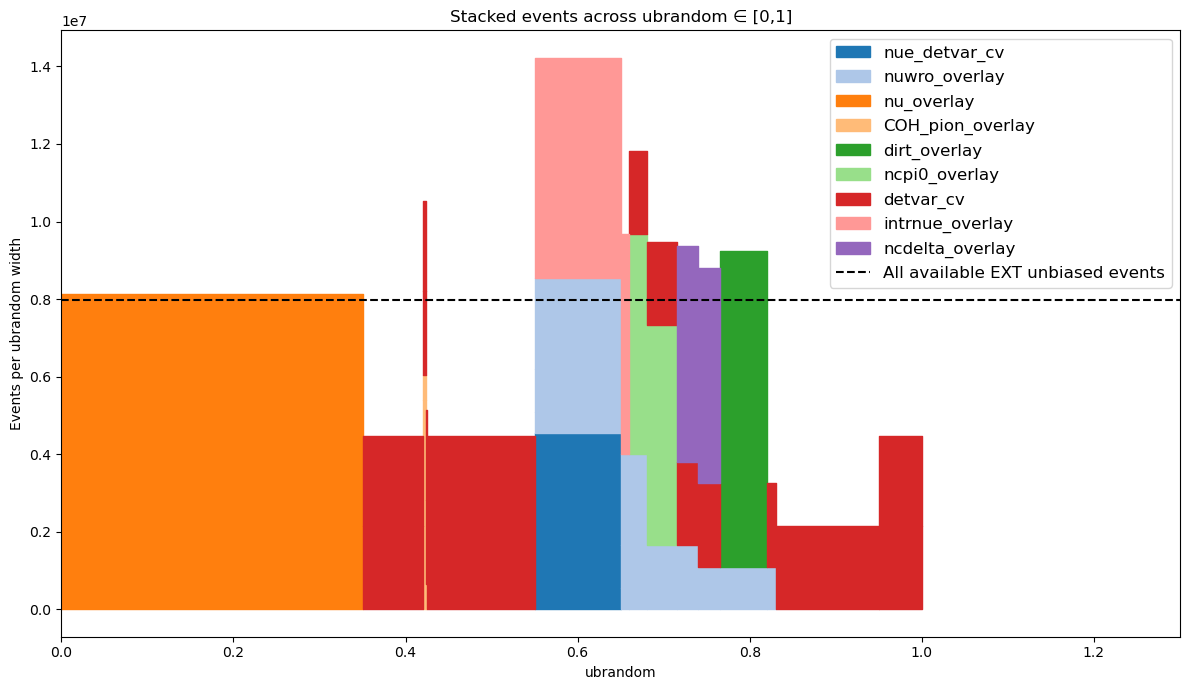

In [5]:
# --- Helper to extract intervals robustly ---
def get_intervals(r):
    # remove all spaces
    r = r.replace(" ", "")
    # match [start,end)
    matches = re.findall(r"\[([\d.]+),([\d.]+)\)", r)
    return [(float(a), float(b)) for a,b in matches]

# --- Build dataframe ---
df = pd.DataFrame({
    "filename": filenames,
    "events": pd.to_numeric(event_nums, errors="coerce"),
    "range": random_range_strs
}).dropna()

# Use filename as sample
df["sample"] = df["filename"]

# --- Collect all unique split points ---
split_points = set()
for r in df["range"]:
    intervals = get_intervals(r)
    for a,b in intervals:
        split_points.add(a)
        split_points.add(b)

split_points = sorted(split_points)
split_points = np.array(split_points)

# --- Expand each line into sub-intervals ---
expanded = []
for _, row in df.iterrows():
    intervals = get_intervals(row["range"])
    if not intervals:
        continue
    
    # total width of all intervals for proportional distribution
    total_width = sum(end - start for start, end in intervals)
    
    for start, end in intervals:
        interval_width = end - start
        events_in_interval = row["events"] * (interval_width / total_width)
        
        for i in range(len(split_points)-1):
            sub_start = split_points[i]
            sub_end = split_points[i+1]
            # check overlap
            overlap_start = max(sub_start, start)
            overlap_end = min(sub_end, end)
            if overlap_end <= overlap_start:
                continue
            overlap_width = overlap_end - overlap_start
            events_in_subinterval = events_in_interval * (overlap_width / interval_width)
            expanded.append({
                "sample": row["sample"],
                "start": overlap_start,
                "end": overlap_end,
                "events": events_in_subinterval
            })

df2 = pd.DataFrame(expanded)

# --- Prepare for plotting ---
samples = df2["sample"].unique()
colors = plt.cm.tab20.colors

fig, ax = plt.subplots(figsize=(12,7))

# Initialize bottom for stacking
bottoms = np.zeros(len(split_points)-1)
already_labeled_sample_names = []

for i, sample in enumerate(samples):
    sample_intervals = df2[df2["sample"]==sample]
    for _, row in sample_intervals.iterrows():
        idx = np.where(split_points[:-1] == row["start"])[0][0]
        event_per_width = row["events"] / (row["end"] - row["start"])
        ax.fill_between(
            [row["start"], row["end"]],
            bottoms[idx:idx+1],
            bottoms[idx:idx+1] + event_per_width,
            step="post",
            color=colors[i % len(colors)],
            label=sample if sample not in already_labeled_sample_names else None
        )
        bottoms[idx:idx+1] += event_per_width
        already_labeled_sample_names.append(sample)


ax.axhline(y=573419+1841799+1086278+2152781+2317232, color='black', linestyle='--', label="All available EXT unbiased events")

ax.set_xlim(0,1.3)
ax.set_xlabel("ubrandom")
ax.set_ylabel("Events per ubrandom width")
ax.set_title("Stacked events across ubrandom ∈ [0,1]")
ax.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()
